# Transfer Learning for Image Classification with TensorFlow

**Author**: Thien Tran (tran0096@e.ntu.edu.sg)

**Last update**: 01 October 2020

This notebook is part of MLDA@EEE's series of workshops during the Deep Learning week 2020.

Designed to run in Google Colab.

## Connect to GPU instance
To connect to GPU instance on Google Colab, follow the instruction below
- Edit > Notebook settings > Hardware accelerator > GPU

# Notebook outline
1. Download data from Kaggle
2. Choose a pre-trained model
3. Data preparation
4. Model training
5. Model evaluation
6. Test with your own image
7. Train with small dataset
8. Visualize feature vectors

## Download data 

We are using `Intel Image Classification` dataset from Kaggle

Data source: https://www.kaggle.com/puneet6060/intel-image-classification

In [1]:
# install kaggle CLI to download the dataset from Kaggle
!pip install -q kaggle

### Task
- Generate your Kaggle token under My account > API > Create New API Token
- Upload your Kaggle token `kaggle.json` to the Google Colab instance

In [2]:
# copy token to .kaggle/ folder and set appropriate permission
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d puneet6060/intel-image-classification

 93% 321M/346M [00:12<00:01, 18.2MB/s]
100% 346M/346M [00:12<00:00, 28.8MB/s]


In [4]:
# Unzip the zip file with unzip
!unzip -q 'intel-image-classification'

The dataset is downloaded and unzipped

In [5]:
import numpy as np                  # numerical calculations
import pandas as pd                 # organize data in DataFrame (table)
import matplotlib.pyplot as plt     # visualize data
import seaborn as sns

import tensorflow as tf             # deep learning framework
import tensorflow_hub as hub        # access pre-trained models

# Choose model architecture

The model you choose must correspond to the task (**Multi-class Image Classification**) and has good performance. The size of the model should also be suitable to the size of our training set (~14,000 images).

## Load a pre-trained model

There are many ways load pre-trained models in TensorFlow. Two recommended ways are
1. Import a pre-trained model from TensorFlow hub as a Keras layer
2. Load a pre-trained model from Keras `tf.keras.applications`

You also need to specify the input image dimensions to create the model. You can find this information on the page you obtain the pre-trained model.

> Link to TensorFlow Hub: https://tfhub.dev/

> List of pre-trained models in Keras: https://www.tensorflow.org/api_docs/python/tf/keras/applications

From my personal experience, the same model architecture in Keras performs worse compared to TensorFlow Hub's, in both accuracy and training speed. Thus I personally recommend TensorFlow Hub over Keras for obtainingpre-trained models.

**NOTE**: you can find many people re-implement neural network architecture online and can be downloaded from PyPI. However, it is not recommended to do so, because there might be mistakes in implementation and missing pre-trained weights. Thus it is only recommnded to use pre-trained models from official and established sources 

### Task
- Choose a pre-trained model from TensorFlow Hub. Use the `feature-vector` version, not the `classification` one
- Follow the provided instructions to create a pre-trained model
- Specify the correct image dimension for your chosen pre-trained model
- Specify the number of classes

Use `model.summary()` to see summary of your model.

In [6]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)

NUM_CLASSES = 6

> To have better numerical stability during training, it's a common practice to not use softmax activation at the last classification layer (dense layer) and indicate `from_logits=True` in the loss function (see Model training later)

In [7]:
# Load pre-trained model from TensorFlow Hub
hub_url = "https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/4"
hub_model = hub.KerasLayer(hub_url, trainable=False)

model = tf.keras.Sequential([
    hub_model,                          # obtain feature vector from a pre-trained neural network  
    tf.keras.layers.Dense(NUM_CLASSES)  # classification layer. number of units = number of classes
])
model.build([None, IMG_HEIGHT, IMG_WIDTH, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23561152  
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,573,446
Trainable params: 12,294
Non-trainable params: 23,561,152
_________________________________________________________________


# Data Preparation

Your pre-trained model expects image input to be in certain format and sizes. Check with the site where you obtain the pre-trained model to prepare the data correctly.
> e.g. Resnet V1 50 on TensorFlow Hub expects images to have **values** within `[0, 1]` and of the **size** `224 x 224` pixels

We have the following folder structure (see `seg_train/seg_train`)
```
class1
    |---10001.jpg
    |---10002.jpg
    ...
class2
    |---20001.jpg
    |---20002.jpg
    ...
```

Keras `image_dataset_from_directory` provides a convenient way to import images with this folder structure. It only loads images when needed, so we don't need to load the whole image dataset into memory.

### Task
- Write down the path to train and test folder

In [8]:
TRAIN_PATH = 'seg_train/seg_train'
TEST_PATH = 'seg_test/seg_test'

## image_dataset_from_directory()

We can use the function `image_dataset_from_directory()` to load the images in the train and test directories. Important parameters are:
- `directory`: where to look for images
- `batch_size`: size of 1 batch of the data (see below)
- `image_size`: this is the image dimension as you have defined above
- `shuffle`: whether TensorFlow should shuffle the data (You shouldn't shuffle the test set)

### About batching
We can't load the whole dataset to memory, so we have to divide the dataset into batches. 
- Batch size must be a power of 2 (e.g. 16, 32, 64) to fit in GPU memory nicely
- The larger the batch size, the faster the training process
- Rule of thumb is to choose the largest batch size that can fit into your GPU memory

**NOTE**: If later at training stage, you face Out of Memory error, you should go back at this step and reduce the batch size. 

You can read more about other parameters here: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

### Task
- Create train and test set using `image_dataset_from_directory()` and specify the correct arguments

In [9]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_PATH,
    batch_size=BATCH_SIZE,
    image_size=IMG_DIM,
    shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_PATH,
    batch_size=BATCH_SIZE,
    image_size=IMG_DIM,
    shuffle=False
)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


We can save the classes that TensorFlow has discovered in a separate variable from the attribute `.class_names`

In [10]:
CLASSES = train_ds.class_names
CLASSES

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

## TensorFlow Dataset API

TensorFlow Dataset is a computational graph, meaning the values and operations are not calculated until they are needed. We can use the method `.map()` to apply some operations and transformations to the dataset. Two operations we will apply here:
- Normalize the image values to `[0,1]` (most TensorFlow Hub models require this)
- Apply augmentation to training data

**NOTE**: Since TensorFlow Dataset builds a computational graph, you MUST use TensorFlow functions and operations inside the `.map()` method

> `.prefetch()` is an optimization feature of TensorFlow Dataset. TensorFlow will start import and prepare the next batch of images while the previous batch is being used for training. Thus this will reduce I/O blocking.

In [11]:
def normalize(imgs, labels):
    # convert [0,255] to [0,1]
    imgs = imgs/255
    return imgs, labels
    
def augment(imgs, labels):
    # here I apply only 2 augmentation methods: random flip left right and random crop
    imgs = tf.image.random_flip_left_right(imgs)

    # scale image up to (IMG_WIDTH*1.5) x (IMG_HEIGHT*1.5) then crop back the original size
    new_width = int(IMG_WIDTH*1.5)
    new_height = int(IMG_HEIGHT*1.5)
    imgs_shape = tf.shape(imgs)
    imgs = tf.image.resize(imgs, (new_width, new_height))
    imgs = tf.image.random_crop(imgs, imgs_shape)

    return imgs, labels

train_ds = train_ds.map(normalize, num_parallel_calls=AUTOTUNE).map(augment, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
test_ds = test_ds.map(normalize, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

We can use the method `.take(n)` to take `n` batches of data from the dataset. Then we can visualize the images together with their corresponding labels.

The class label number corresponds to the position in the `CLASSES` list.

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


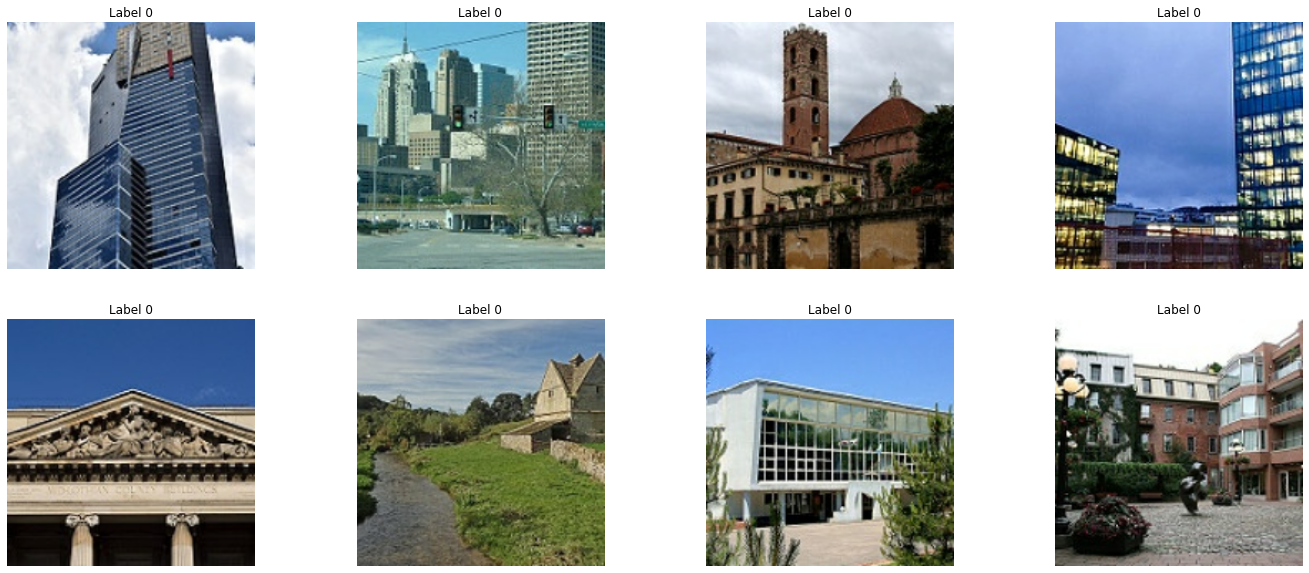

In [12]:
plt.figure(figsize=(24,10))

for imgs, labels in test_ds.take(1):
    # take 1 batch. each batch has BATCH_SIZE samples
    for i in range(8):
        plt.subplot(2,4,i+1)
        image = imgs[i]
        label = labels[i]
        plt.imshow(image)
        plt.axis('off')
        plt.title('Label ' + str(label.numpy()))
        
print(CLASSES)

## (Advanced topic) Image augmentation
Image augmentation plays a crucial part in neural network training and transfer learning. It prevents overfitting and helps generating more data when dataset is limited.

Some modern, State-of-the-Art image augmentation techniques include:

Technique | Year published | Link
----------|----------------|------
Cutout | 2017 | https://arxiv.org/abs/1708.04552
Mixup | 2017 | https://arxiv.org/pdf/1710.09412.pdf
Hide and Seek | 2018 | https://arxiv.org/abs/1811.02545
CutMix | 2019 | https://arxiv.org/pdf/1905.04899.pdf
GridMask | 2020 | https://arxiv.org/abs/2001.04086

Cutout is currently available in TensorFlow Addons nightly build [here](https://www.tensorflow.org/addons/api_docs/python/tfa/image/random_cutout). To use other augmentation techniques in TensorFlow, you have to implement them yourself (or Google someone who has done it)

<br>

Key considerations in using Image augmentation
- **Speed**: apply too many augmentations can slow down the training process significantly, because the CPU/GPU has to apply transformations to the images before feeding to the neural network.
- **Effectiveness**: not all augmentation techniques are the same in generalizing the data. 

# Model training

## Compile the model

You need a **loss** function and an **optimizer** for TensorFlow to know how to train your model.
- The **loss** (sometimes called the cost) is a function that measures how well (or how badly) our model performs with the dataset
- The **optimizer** is a mathematical method to minimize the loss, so that our model will become better, hence 'trained'

### Losses

The loss usually depends on your task and how to prepare your dataset output. Our task is Multi-class Image Classification, so you can find an appropriate loss function for this task.

> To provide better numerical stability for the loss, it's a common practice to not use softmax activation at the last classification layer (dense layer) and indicate `from_logits=True` in the loss function

<br>

### Optimizers

Some popular optimizers to choose from are SGD, Adam and RMSprop.
- **SGD** is the traditional optimizer. It is slower than Adam and RMSprop, but generally converges to better minima than Adam and RMSprop
- **Adam** and **RMSprop** are adaptive learning rate optimizers. They are much faster than SGD.

![Visualize optimizers](https://rnrahman.com/img/visualising-optim/saddle.gif)

(Credits to [Ridlo Rahman](https://rnrahman.com/blog/visualising-stochastic-optimisers/))

> You can read more about different types of optimizers here: https://mlfromscratch.com/optimizers-explained/

<br>

From my personal experience:
- If you don't have much time, use **Adam**. Chances are, with a pre-trained model, you only need to train 1-5 epochs to get excellent performance. Note that training more epochs with Adam quickly leads to over-fitting.
- If you have enough time, use **SGD**. Although training time is much longer, the better performance from SGD optimizer may be worth it for your use case.

### Task

- Find and use an optimizer from `tf.keras.optimizers` https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
- Find and use a loss from `tf.keras.losses` https://www.tensorflow.org/api_docs/python/tf/keras/losses
- Default metrics is Accuracy (`acc`). You can add more metrics if you want https://www.tensorflow.org/api_docs/python/tf/keras/metrics

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc'],
)

## Start the training

Information about the training process (e.g. training loss, validation loss) is saved in a `history` object, which is returned by the method `.fit()`. We can access this history object later to inspect the training process

### Task
- Specify your train and test set
- Choose how many epochs you want to train for

In [14]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds
)

Epoch 1/10
110/110 [==============================] - 38s 348ms/step - loss: 0.5309 - acc: 0.8042 - val_loss: 0.2970 - val_acc: 0.8903
Epoch 2/10
110/110 [==============================] - 38s 341ms/step - loss: 0.3170 - acc: 0.8849 - val_loss: 0.2647 - val_acc: 0.9010
Epoch 3/10
110/110 [==============================] - 38s 345ms/step - loss: 0.2938 - acc: 0.8948 - val_loss: 0.2488 - val_acc: 0.9090
Epoch 4/10
110/110 [==============================] - 38s 344ms/step - loss: 0.2834 - acc: 0.8977 - val_loss: 0.2392 - val_acc: 0.9110
Epoch 5/10
110/110 [==============================] - 37s 341ms/step - loss: 0.2764 - acc: 0.8983 - val_loss: 0.2346 - val_acc: 0.9097
Epoch 6/10
110/110 [==============================] - 38s 345ms/step - loss: 0.2697 - acc: 0.9042 - val_loss: 0.2333 - val_acc: 0.9147
Epoch 7/10
110/110 [==============================] - 37s 339ms/step - loss: 0.2638 - acc: 0.9051 - val_loss: 0.2267 - val_acc: 0.9157
Epoch 8/10
110/110 [==============================] - 3

## Visualize training process

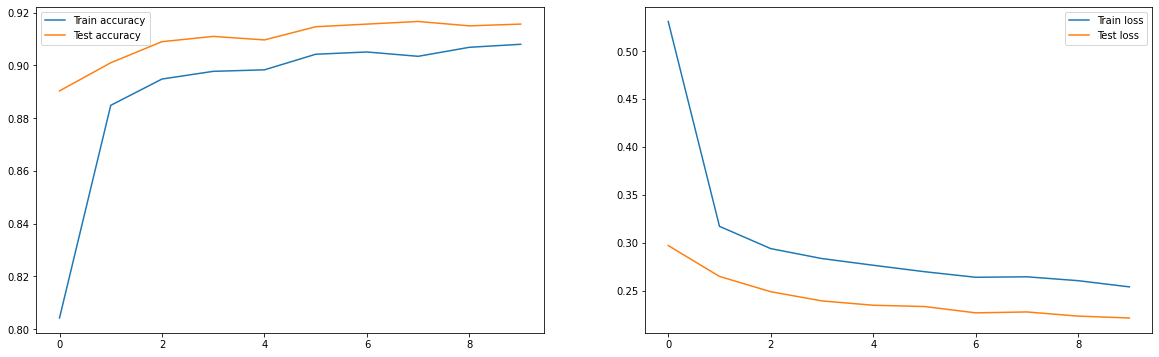

In [15]:
# get values from history object
acc_history      = history.history['acc']
val_acc_history  = history.history['val_acc']
loss_history     = history.history['loss']
val_loss_history = history.history['val_loss']

# create a figure
plt.figure(figsize=(20,6))

# plot train and test accuracies
plt.subplot(1,2,1)
plt.plot(acc_history)
plt.plot(val_acc_history)
plt.legend(['Train accuracy', 'Test accuracy'])

# plot train and test losses
plt.subplot(1,2,2)
plt.plot(loss_history)
plt.plot(val_loss_history)
plt.legend(['Train loss', 'Test loss'])

## (Advanced topic) Learning rate scheduler, Hyperparameters search, and early stopping for SGD optimizer

**Learning rate scheduler**: we want to decrease the learning rate as we get closer to the minima. This can be achieved with `tf.keras.callbacks.LearningRateScheduler`. Some popular methods are:
- Learning rate exponential decay
- Learning rate stepped decay
- Learning rate warm up (good for transfer learning)

**Hyperparameters search**: there are many hyperparameters during training that affect the final model's accuracy, such as learning rate and learning rate schedule. We can try different sets of hyperparameters to find the best combination.
- When changing a hyperparameter value, change its order of magnitude e.g. `learning_rate=0.001` and `learning_rate=0.0001`

**Early stopping**: when to stop training? How to detect overfitting? We can train the model for many epochs (e.g. 100-200 epochs) to see its long term trends. Plotting the accuracy and loss graph over time, which reveal when the model starts to overfit (training loss still drops but validation loss starts to increase). We can re-train the model up to that epoch to get the best performance

# Model evaluation - Confusion matrix

Get predictions with the method `.predict()`

In [16]:
# get predictions from test set
logits = model.predict(test_ds)

We can get an array of grouth truth label from the test set by iterating over it and only extract the label part

In [17]:
# get labels (ground truth) from test set
labels = []

for _, label_b in test_ds:
    labels.append(label_b)
    
labels = np.concatenate(labels)
print(labels.shape)
labels

(3000,)


array([0, 0, 0, ..., 5, 5, 5], dtype=int32)

If you don't include the softmax activation at the classification layer, the output will be logits instead of probabilities. To convert to probabilities, you just need to apply softmax function to the logits.

To get the number label, find position of the largest probability with `np.argmax()`

In [18]:
probs = tf.nn.softmax(logits)               # convert to probability by applying softmax function
preds = np.argmax(probs.numpy(), axis=1)    # get the index of largest probability
preds

array([0, 0, 0, ..., 3, 5, 5])

We can visualize the performance of the model with a confusion matrix. Note that the horizontal axis is **predictions**, while the vertical axis is **ground truth labels**

Text(80.52000000000001, 0.5, 'Labels')

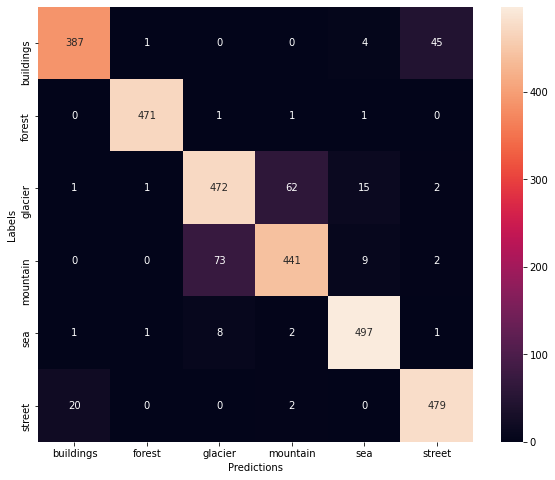

In [19]:
conf_matrix = tf.math.confusion_matrix(labels, preds)

plt.figure(figsize=(10,8))
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', square=True, xticklabels=CLASSES, yticklabels=CLASSES)
heatmap.set_xlabel('Predictions')
heatmap.set_ylabel('Labels')

# Test with your own image!

Upload your own image to the Colab instance. Ideally, use an image from the classes that we have trained.

We don't want to use an image of objects that the model hasn't seen before (aka out of distribution). However, feel free to try and see what your model predicts!

In [20]:
CLASSES

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

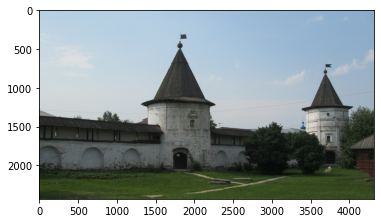

In [21]:
test_img = 'IMG_2134.JPG'
test_img = tf.io.read_file(test_img)
test_img = tf.image.decode_jpeg(test_img)

plt.imshow(test_img)

In [22]:
# prepare image input before feeding to the model
test_img = tf.image.convert_image_dtype(test_img, tf.float32)       # convert from [0,255] to [0,1]
test_img = tf.image.resize(test_img, (IMG_WIDTH, IMG_HEIGHT))       # resize
test_img = tf.expand_dims(test_img, axis=0)                         # add the batch dimension
test_img.shape                                                      # now image has the shape (1, height, width, channel)

TensorShape([1, 224, 224, 3])

In [23]:
logits = model.predict(test_img)
logits

array([[ 5.713496  , -2.9655864 , -3.2395108 , -1.6711704 , -0.11579783,
         2.2010198 ]], dtype=float32)

In [24]:
probs = tf.nn.softmax(logits)
probs = probs.numpy()[0]
probs

array([9.6741432e-01, 1.6456394e-04, 1.2513278e-04, 6.0047180e-04,
       2.8443441e-03, 2.8851166e-02], dtype=float32)

In [25]:
prediction = np.argmax(probs)
print(prediction)
CLASSES[prediction]

0


'buildings'

In [26]:
table = pd.DataFrame({'class': list(CLASSES), 'probability': probs})
table['probability'] = table['probability'].map('{:5f}'.format)
table

,class,probability
0,buildings,0.967414
1,forest,0.000165
2,glacier,0.000125
3,mountain,0.000600
4,sea,0.002844
5,street,0.028851


# Train with small dataset

Now we will repeat the process, but with only 100 training images, meaning around 17 images per class

In [27]:
train100_ds = train_ds.take(100//BATCH_SIZE+1)

In [28]:
# Load pre-trained model from TensorFlow Hub
hub_url = "https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/4"
hub_model = hub.KerasLayer(hub_url, trainable=False)

model = tf.keras.Sequential([
    hub_model,                          # obtain feature vector from a pre-trained neural network  
    tf.keras.layers.Dense(NUM_CLASSES)  # classification layer. number of units = number of classes
])
model.build([None, IMG_HEIGHT, IMG_WIDTH, 3])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              23561152  
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 12294     
Total params: 23,573,446
Trainable params: 12,294
Non-trainable params: 23,561,152
_________________________________________________________________


In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

In [30]:
history = model.fit(
    train100_ds,
    epochs=10
)

Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 2.2897 - acc: 0.1484
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 1.9200 - acc: 0.2422
Epoch 3/10
1/1 [==============================] - 0s 3ms/step - loss: 1.6180 - acc: 0.3516
Epoch 4/10
1/1 [==============================] - 0s 3ms/step - loss: 1.3500 - acc: 0.4922
Epoch 5/10
1/1 [==============================] - 0s 3ms/step - loss: 1.3485 - acc: 0.5234
Epoch 6/10
1/1 [==============================] - 0s 2ms/step - loss: 1.3434 - acc: 0.4922
Epoch 7/10
1/1 [==============================] - 0s 4ms/step - loss: 0.9912 - acc: 0.6250
Epoch 8/10
1/1 [==============================] - 0s 6ms/step - loss: 0.9887 - acc: 0.6094
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.8366 - acc: 0.7266
Epoch 10/10
1/1 [==============================] - 0s 7ms/step - loss: 0.8445 - acc: 0.6719


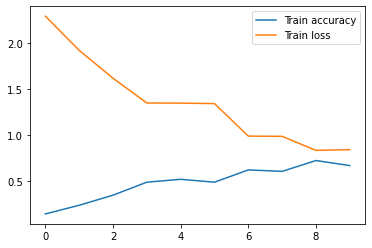

In [31]:
acc = history.history['acc']
loss = history.history['loss']

plt.plot(np.arange(len(acc)), acc)
plt.plot(np.arange(len(loss)), loss)
plt.legend(['Train accuracy', 'Train loss'])

In [32]:
model.evaluate(test_ds)

24/24 [==============================] - 5s 194ms/step - loss: 0.7607 - acc: 0.7200


[0.7607147693634033, 0.7200000286102295]

In [33]:
# confusion matrix
logits = model.predict(test_ds)

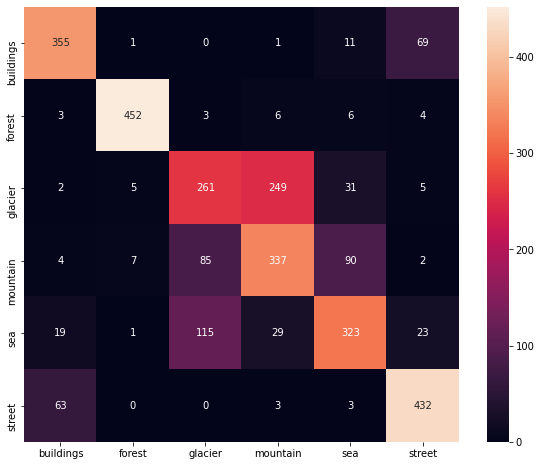

In [34]:
probs = tf.nn.softmax(logits)
preds = np.argmax(probs.numpy(), axis=1)

conf_matrix = tf.math.confusion_matrix(labels, preds)

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', square=True, xticklabels=CLASSES, yticklabels=CLASSES)

In [35]:
logits = model(test_img)
probs = tf.nn.softmax(logits).numpy()[0]

table = pd.DataFrame({'class': list(CLASSES), 'probability': probs})
table['probability'] = table['probability'].map('{:5f}'.format)
table

,class,probability
0,buildings,0.334480
1,forest,0.103125
2,glacier,0.043322
3,mountain,0.031883
4,sea,0.221124
5,street,0.266066


# (Optional) Visualize feature vectors

In [36]:
import os
train_df = pd.DataFrame()

for class_name in CLASSES:
    files = os.listdir(os.path.join(TRAIN_PATH, class_name))
    df = pd.DataFrame({'filename': files, 'class': class_name})
    df['path'] = TRAIN_PATH + '/' + class_name + '/' + df['filename']
    train_df = train_df.append(df, ignore_index=True)

# prepare a TensorFlow Dataset with only image data (no label)
def import_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (224,224))
    return img

train_inputs = tf.data.Dataset.from_tensor_slices(train_df['path']).cache()
train_inputs = train_inputs.map(import_img, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

In [37]:
# build a model with only feature vector ouput
hub_url = "https://tfhub.dev/google/bit/m-r50x1/1"
hub_model = hub.KerasLayer(hub_url, trainable=False)
feature_model = tf.keras.Sequential(hub_model)

In [38]:
features = feature_model.predict(train_inputs)
print(features.shape)  # shape (num_examples, vector_dimension)
features

(14034, 2048)


array([[0.07120739, 0.        , 6.979399  , ..., 0.06791511, 0.07935844,
        0.9184905 ],
       [0.21379927, 0.        , 7.0426784 , ..., 0.0193339 , 0.4044078 ,
        3.9212945 ],
       [0.07115565, 0.        , 3.2409823 , ..., 0.12187979, 0.4688432 ,
        0.41679117],
       ...,
       [0.        , 0.        , 0.6089725 , ..., 0.        , 1.088888  ,
        0.01171893],
       [0.30537915, 0.        , 0.23618437, ..., 0.5824178 , 3.8920093 ,
        0.50984454],
       [0.        , 0.        , 1.4463532 , ..., 0.08398189, 1.2943392 ,
        0.34482926]], dtype=float32)

The features are in a vector space with 2048 dimensions. To visualize it in 3D space, we will reduce the dimensionality with Principal Component Analysis (PCA)

In [39]:
from sklearn.decomposition import PCA
pca = PCA(3)

In [40]:
pca.fit(features)
features_3d = pca.transform(features)

# shape (num_examples, 3)
print(features_3d.shape)
features_3d

(14034, 3)


array([[ 41.32468  , -17.851484 , -11.099093 ],
       [ 29.5293   , -16.544842 ,  -0.7527126],
       [ 43.16166  , -12.62372  , -10.421992 ],
       ...,
       [ 56.043083 ,  -6.017569 , -20.213627 ],
       [ 47.843063 , -11.676751 ,  -5.5972857],
       [ 55.330532 , -11.713578 , -18.789114 ]], dtype=float32)

In [41]:
import plotly.express as px

x = features_3d[:,0]
y = features_3d[:,1]
z = features_3d[:,2]

fig = px.scatter_3d(x=x, y=y, z=z, color=train_df['class'])
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [42]:
img_feature = feature_model(test_img)
img_feature = pca.transform(img_feature)

x_img = np.append(x, img_feature[0,0])
y_img = np.append(y, img_feature[0,1])
z_img = np.append(z, img_feature[0,2])
color_img = np.append(train_df['class'].values, 'Test image')
size_img = [1] * len(train_df) + [10]

fig = px.scatter_3d(
    x=x_img, 
    y=y_img, 
    z=z_img, 
    color=color_img,
    size=size_img
)

fig.update_layout(
    scene=dict(
        annotations=[dict(
            # showarrow=False,
            x=img_feature[0,0],
            y=img_feature[0,1],
            z=img_feature[0,2],
            text="Test image",
        )]
    ),
)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

## (Extra) Persistent storage, save weights and load weights

After you close Google Colab, all of your data is lost. One way to save your progress is to save to Google Drive.

TensorFlow models can save and load weights with `.save_weights()` and `.load_weights()` methods.

From Google Colab, you can mount your Google Drive to Colab instance, and save and load weights directly to and from your Google Drive.

For more information
- https://www.tensorflow.org/tutorials/keras/save_and_load#manually_save_weights